## Dependencias

In [ ]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
from scikitplot.metrics import plot_roc
from sklearn.datasets import load_breast_cancer

from varclushi import VarClusHi
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns 
import cufflinks as cf

from functools import reduce

cf.go_offline()
pd.set_option('display.max_columns',None)

## Carga de datos

In [ ]:
datos = load_breast_cancer()

In [ ]:
X = datos['data']
y = datos['target']


In [ ]:
df = pd.DataFrame(X,columns=datos.feature_names)
df['y'] = y
df['ID'] = df.index+1

In [ ]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,y,ID
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0,2
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0,3
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0,4
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0,5


In [ ]:
df.shape

(569, 32)

In [ ]:
var = list(datos.feature_names)

In [ ]:
train, valid = train_test_split(df,train_size=0.7)
train.reset_index(drop=True,inplace=True),valid.reset_index(drop=True,inplace=True)
train.shape,valid.shape

((398, 32), (171, 32))

## Análisis Exploratorio de datos

### Reducción de dimensiones

#### Multicolinealidad

In [ ]:
vc = VarClusHi(df=train,feat_list=var).varclus()

In [ ]:
var = list(vc.rsquare.sort_values(by=['Cluster','RS_Ratio']).groupby('Cluster').first()['Variable'])

In [ ]:
len(var)

7

### Análisis Univariado

#### Distribución

array([[<Axes: title={'center': 'worst perimeter'}>,
        <Axes: title={'center': 'worst compactness'}>,
        <Axes: title={'center': 'fractal dimension error'}>],
       [<Axes: title={'center': 'worst texture'}>,
        <Axes: title={'center': 'symmetry error'}>,
        <Axes: title={'center': 'mean smoothness'}>],
       [<Axes: title={'center': 'radius error'}>, <Axes: >, <Axes: >]],
      dtype=object)

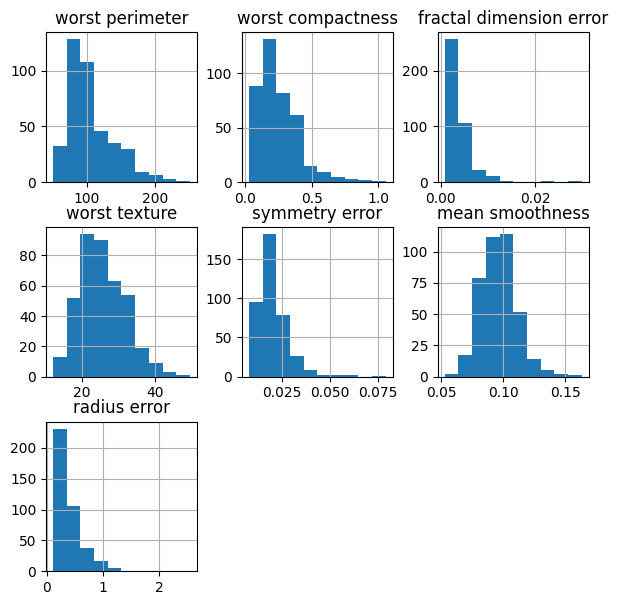

In [ ]:
train[var].hist(figsize=(7,7))

#### Ausentes

In [ ]:
(train[var].isna().sum()/len(train)).to_frame()

,0
worst perimeter,0.0
worst compactness,0.0
fractal dimension error,0.0
worst texture,0.0
symmetry error,0.0
mean smoothness,0.0
radius error,0.0


#### Extremos

In [ ]:
for v,li,ls in train[var].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    train[f'ex_{v}'] = ((train[v]<li)|(train[v]>ls)).astype(int)

In [ ]:
train['ex_'] = train.filter(like='ex_').max(axis=1)

In [ ]:
train['ex_'].value_counts(1)

0    0.884422
1    0.115578
Name: ex_, dtype: float64

In [ ]:
train = train[train['ex_']==0].reset_index(drop=True)

array([[<Axes: title={'center': 'worst perimeter'}>,
        <Axes: title={'center': 'worst compactness'}>,
        <Axes: title={'center': 'fractal dimension error'}>],
       [<Axes: title={'center': 'worst texture'}>,
        <Axes: title={'center': 'symmetry error'}>,
        <Axes: title={'center': 'mean smoothness'}>],
       [<Axes: title={'center': 'radius error'}>, <Axes: >, <Axes: >]],
      dtype=object)

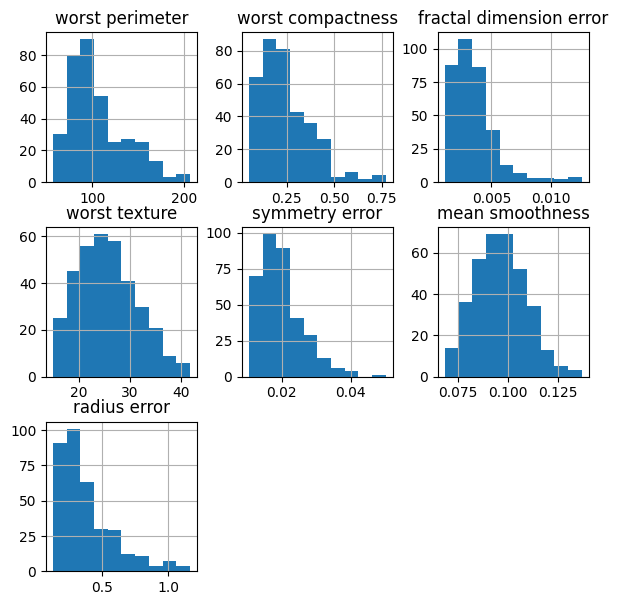

In [ ]:
train[var].hist(figsize=(7,7))

## Análisis de poder predictivo

In [ ]:
#sk = SelectKBest(k=len(var))
sk = SelectKBest(k=4)

In [ ]:
sk.fit(train[var],train['y'])

SelectKBest(k=4)

In [ ]:
pd.Series(dict(zip(sk.get_feature_names_out(),sk.scores_))).sort_values(ascending=False).iplot(kind='bar',color='purple')

In [ ]:
best = [v for v,d in zip(var,sk.get_support()) if d ]

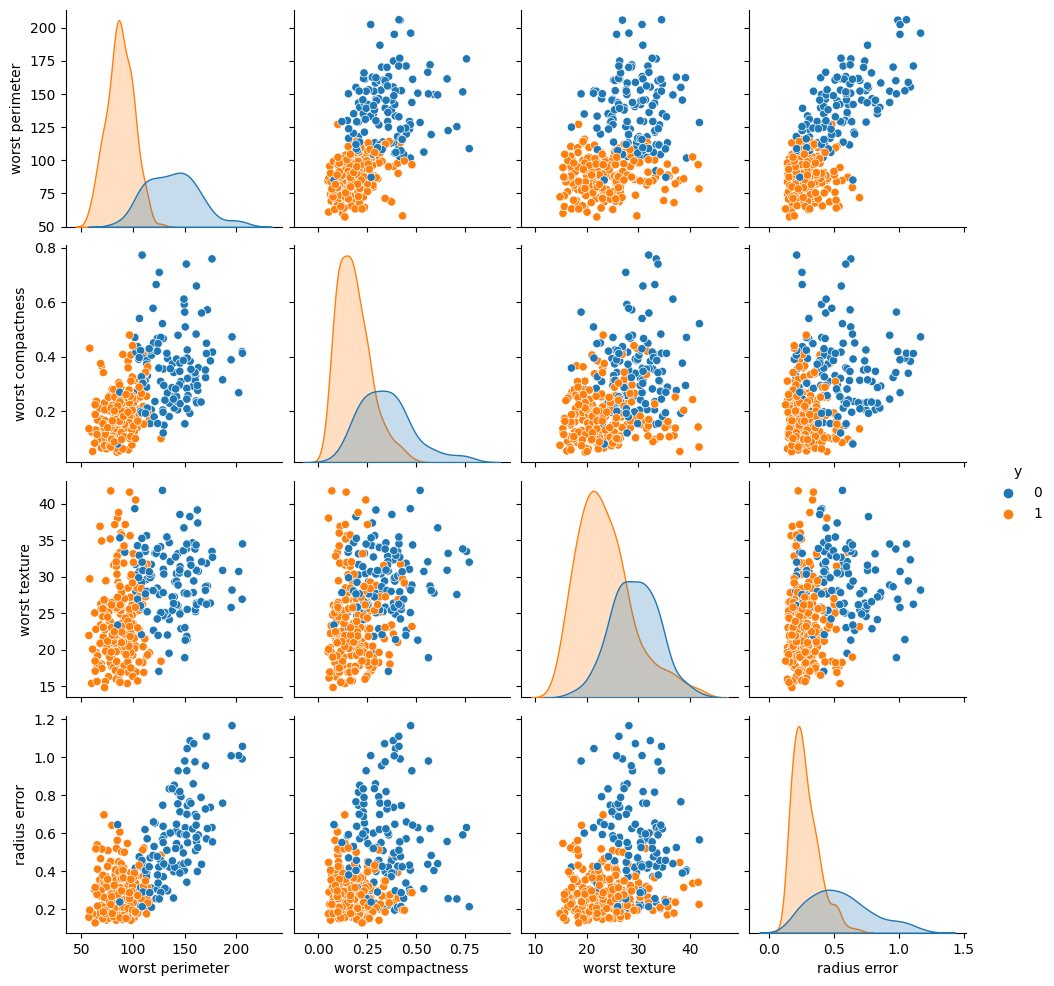

In [ ]:
sns.pairplot(data=train[best+['y']],hue='y')

## Aprendizaje

In [ ]:
lr = LogisticRegression()

### Híper-parametrización

In [ ]:
hiper_param = {'penalty':['l1', 'l2', 'elasticnet', None],'C':np.arange(0.1,2,0.1)}

In [ ]:
reduce(lambda x,y:x*y,map(len,hiper_param.values()))

76

In [ ]:
grid = GridSearchCV(param_grid=hiper_param, n_jobs=-1,
                    estimator=lr, cv=5, verbose=True, scoring='roc_auc')


In [ ]:
grid.fit(train[best],train['y'])

Fitting 5 folds for each of 76 candidates, totalling 380 fits


/home/jose/entornos/tsc2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jose/entornos/tsc2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jose/entornos/tsc2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jose/entornos/tsc2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jose/entornos/tsc2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jose/entornos/tsc2/lib/python3.10/site-packages/sklearn/lin

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                         'penalty': ['l1', 'l2', 'elasticnet', None]},
             scoring='roc_auc', verbose=True)

In [ ]:
lr = grid.best_estimator_
lr

LogisticRegression(C=0.1, penalty=None)

In [ ]:
grid.best_score_

0.986625641025641

### Parámetros $\vec{\theta},\theta_0$

In [ ]:
lr.fit(train[best],train['y'])

/home/jose/entornos/tsc2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters



LogisticRegression(C=0.1, penalty=None)

In [ ]:
lr.coef_,lr.intercept_

(array([[-0.15713022, -8.67692734, -0.25132952, -7.7769492 ]]),
 array([28.99710941]))

### Métricas de ajuste

In [ ]:
train['y^'] = lr.predict(train[best])
valid['y^'] = lr.predict(valid[best])

train['proba'] = lr.predict_proba(train[best])[:,1]
valid['proba'] = lr.predict_proba(valid[best])[:,1]

In [ ]:
help(plot_roc)

Help on function plot_roc in module scikitplot.metrics:

plot_roc(y_true, y_probas, title='ROC Curves', plot_micro=True, plot_macro=True, classes_to_plot=None, ax=None, figsize=None, cmap='nipy_spectral', title_fontsize='large', text_fontsize='medium')
    Generates the ROC curves from labels and predicted scores/probabilities
    
    Args:
        y_true (array-like, shape (n_samples)):
            Ground truth (correct) target values.
    
        y_probas (array-like, shape (n_samples, n_classes)):
            Prediction probabilities for each class returned by a classifier.
    
        title (string, optional): Title of the generated plot. Defaults to
            "ROC Curves".
    
        plot_micro (boolean, optional): Plot the micro average ROC curve.
            Defaults to ``True``.
    
        plot_macro (boolean, optional): Plot the macro average ROC curve.
            Defaults to ``True``.
    
        classes_to_plot (list-like, optional): Classes for which the ROC
    

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

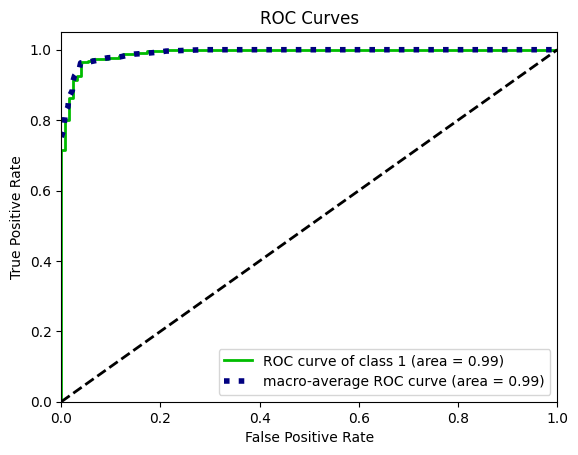

In [ ]:
plot_roc(y_probas=lr.predict_proba(
    train[best]), y_true=train['y'], plot_macro=True, plot_micro=False, classes_to_plot=[1])


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

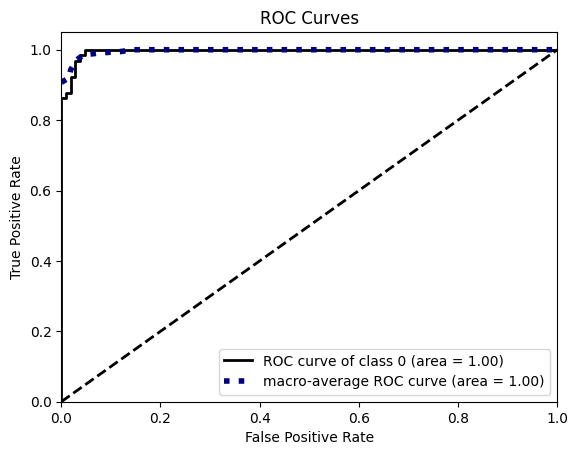

In [ ]:
plot_roc(y_probas=lr.predict_proba(
    valid[best]), y_true=valid['y'], plot_macro=True, plot_micro=False, classes_to_plot=[1])


In [ ]:
valid['y'].value_counts(True)

1    0.619883
0    0.380117
Name: y, dtype: float64

In [ ]:
accuracy_score(y_true=valid['y'],y_pred=valid['y^'])

0.9707602339181286

In [ ]:
confusion_matrix(y_true=valid['y'],y_pred=valid['y^'])

array([[ 63,   2],
       [  3, 103]])